In [79]:
import numpy as np
import pandas as pd

from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import scipy.stats
    
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn import preprocessing
from sklearn import decomposition

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [80]:
# Lecture des fichiers csv.
df_pop = pd.read_csv('pop_mondiale2008-2013.csv', sep=',')
df_dispo = pd.read_csv('dispo_prot+cal_2013.csv', sep=',')
df_prot_animale = pd.read_csv('dispo_prot_animale_2013.csv', sep=',')
df_import_vol = pd.read_csv('import_volailles_0813.csv', sep=',')
df_pib = pd.read_csv('PIB_par_habitant_2013.csv', sep=',')

In [81]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(10,10))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [82]:
# On crée la fonction pour réaliser les Dendrogram
def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        color_threshold=100,
        above_threshold_color='black',
        orientation = "left",
    )
    plt.show()

In [83]:
# On crée la fonction pour réaliser les Dendrogram
def plot_dendrogram2(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        color_threshold=3,
        above_threshold_color='grey',
        orientation = "left",
    )
    plt.show()

# Table avec le PIB par habitant 

In [84]:
df_pib=df_pib.groupby(['Zone'])['Valeur'].sum().reset_index()
df_pib['Pays']=df_pib['Zone']
df_pib['PIB/hab ($)']=df_pib['Valeur']
df_pib=df_pib.drop(columns=['Valeur'])
df_pib=df_pib.drop(columns=['Zone'])

# Table avec les valeurs de population humaine et le ratio de différence entre 2013 et 2008

In [85]:
df_pop=df_pop.groupby(['Code Pays','Pays','Année'])['Valeur'].sum().reset_index() # on prends uniquement la population pour les années qui nous intéresse
df_pop.rename(columns={'Valeur':'Population'}, inplace=True) # on renome la colonne
df_pop['Population']=df_pop['Population']*1000 # on met dans la bonne unité
df_pop=pd.merge(df_pop,df_pib,on='Pays')
df_pop.head()

,Code Pays,Pays,Année,Population,PIB/hab ($)
0,1,Arménie,2008,2977000,3843.590751
1,1,Arménie,2013,2977000,3843.590751
2,2,Afghanistan,2008,27032000,681.033974
3,2,Afghanistan,2013,30552000,681.033974
4,3,Albanie,2008,3157000,4376.970549


In [86]:
# On crée la table qui va nous permettre d'avoir le % Différence de population entre 2008 et 2013
df_pop1=df_pop.pivot_table(index='Pays', columns='Année', values='Population', fill_value=0)
df_pop1=df_pop1.reset_index()
df_pop1.head()

Année,Pays,2008,2013
0,Afghanistan,27032000,30552000
1,Afrique du Sud,50267000,52776000
2,Albanie,3157000,3173000
3,Algérie,35725000,39208000
4,Allemagne,83380000,82727000


In [87]:
df_pop2013=df_pop1[['Pays',2013]]

In [88]:
# on ajoute la colonne pour le calcul de %
df_pop1['pop. growth (%)']=((df_pop1[2013]/df_pop1[2008])-1).round(2)
df_pop1['pop. growth (%)']=df_pop1['pop. growth (%)']*100
df_pop1=df_pop1.drop(columns=[2013])
df_pop1=df_pop1.drop(columns=[2008])
df_pop1.head()

Année,Pays,pop. growth (%)
0,Afghanistan,13.0
1,Afrique du Sud,5.0
2,Albanie,1.0
3,Algérie,10.0
4,Allemagne,-1.0


In [89]:
df_pop=pd.merge(df_pop1,df_pib,on='Pays')

In [90]:
df_dispo.head()

,Code Domaine,Domaine,Code Pays,Pays,Code Élément,Élément,Code Produit,Produit,Code Année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Bilans Alimentaires,2,Afghanistan,664,Disponibilité alimentaire (Kcal/personne/jour),2511,Blé,2013,2013,Kcal/personne/jour,1369.00,Fc,Donnée calculée
1,FBS,Bilans Alimentaires,2,Afghanistan,674,Disponibilité de protéines en quantité (g/pers...,2511,Blé,2013,2013,g/personne/jour,36.91,Fc,Donnée calculée
2,FBS,Bilans Alimentaires,2,Afghanistan,664,Disponibilité alimentaire (Kcal/personne/jour),2805,Riz (Eq Blanchi),2013,2013,Kcal/personne/jour,141.00,Fc,Donnée calculée
3,FBS,Bilans Alimentaires,2,Afghanistan,674,Disponibilité de protéines en quantité (g/pers...,2805,Riz (Eq Blanchi),2013,2013,g/personne/jour,2.70,Fc,Donnée calculée
4,FBS,Bilans Alimentaires,2,Afghanistan,664,Disponibilité alimentaire (Kcal/personne/jour),2513,Orge,2013,2013,Kcal/personne/jour,26.00,Fc,Donnée calculée


# Table avec les dispos alimentaires totales en protéine et calories

In [91]:
df_dispo=df_dispo.groupby(['Code Pays','Pays','Unité'])['Valeur'].sum().reset_index() # on prends les valeurs qui nous intéressent
df_dispo.reset_index()
# On isole les valeurs qui nous intéresse
df_dispo=df_dispo.pivot_table(index='Pays', columns=['Unité'], values='Valeur', fill_value=0)
df_dispo=df_dispo.reset_index()
df_dispo['Kcal/personne/jour']=df_dispo['Kcal/personne/jour']*365 # on calcule sur 1 l'année
df_dispo['g/personne/jour']=df_dispo['g/personne/jour']*365
df_dispo.rename(columns={'Kcal/personne/jour':'dispo alim (kcal/pers/an)'}, inplace=True)
df_dispo.rename(columns={'g/personne/jour':'dispo prot (g/pers/an)'}, inplace=True)
df_dispo=df_dispo.reset_index()
df_dispo=df_dispo.drop(columns=['index'])
df_dispo.head()
df_dispo.head()
df_dispo.head()


Unité,Pays,dispo alim (kcal/pers/an),dispo prot (g/pers/an)
0,Afghanistan,761755,21264.90
1,Afrique du Sud,1102300,31145.45
2,Albanie,1163620,40650.05
3,Algérie,1201945,33550.80
4,Allemagne,1278595,37007.35


# Table avec la proportion de dispo en protéine animale sur la dispo en protéine totale

In [92]:
df_prot_animale=df_prot_animale.groupby(['Code Pays','Pays'])['Valeur'].sum().reset_index()
df_prot_animale.rename(columns={'Valeur':'dispo prot animale (g/pers/an)'}, inplace=True) # on renome la colonne
df_prot_animale['dispo prot animale (g/pers/an)']=df_prot_animale['dispo prot animale (g/pers/an)']*365 # On met sur l'année
df_prot_animale.head()

,Code Pays,Pays,dispo prot animale (g/pers/an)
0,1,Arménie,15782.60
1,2,Afghanistan,4456.65
2,3,Albanie,21684.65
3,4,Algérie,9117.70
4,7,Angola,6716.00


In [93]:
df_dispo=pd.merge(df_dispo,df_prot_animale,on='Pays')

In [94]:
# on calcule le ratio de dispo prot animale sur dispo prot totale
df_dispo['prop. prot animale (%)']=(df_dispo['dispo prot animale (g/pers/an)']/df_dispo['dispo prot (g/pers/an)']).round(3)
df_dispo.head()

,Pays,dispo alim (kcal/pers/an),dispo prot (g/pers/an),Code Pays,dispo prot animale (g/pers/an),prop. prot animale (%)
0,Afghanistan,761755,21264.90,2,4456.65,0.210
1,Afrique du Sud,1102300,31145.45,202,13282.35,0.426
2,Albanie,1163620,40650.05,3,21684.65,0.533
3,Algérie,1201945,33550.80,4,9117.70,0.272
4,Allemagne,1278595,37007.35,79,22443.85,0.606


# Table avec importations de volailles

In [95]:
# on regroupe les importations de volaille par année
df_import_vol=df_import_vol.groupby(['Pays','Année'])['Valeur'].sum().reset_index()
df_import_vol.rename(columns={'Valeur':'Imp. volailles (k tonnes)'}, inplace=True) # on renome la colonne
df_import_vol=df_import_vol.pivot_table(index='Pays', columns='Année', values='Imp. volailles (k tonnes)', fill_value=0)
df_import_vol=df_import_vol.reset_index()
df_import_vol.head()

Année,Pays,2008,2013
0,Afghanistan,32,48
1,Afrique du Sud,202,356
2,Albanie,24,25
3,Algérie,1,3
4,Allemagne,632,788


In [96]:
# on calcule le ratio et garde uniquement la valeur totale d'import de 2013
df_import_vol['growth chicken imp. (%)']=((df_import_vol[2013]/df_import_vol[2008])-1).round(2)
df_import_vol['growth chicken imp. (%)']=df_import_vol['growth chicken imp. (%)']*100
df_import_vol=df_import_vol.drop(columns=[2008])
df_import_vol.rename(columns={2013:'imp. chicken 2013 (k tonnes)'}, inplace=True) # on renome la colonne
df_import_vol.head()

Année,Pays,imp. chicken 2013 (k tonnes),growth chicken imp. (%)
0,Afghanistan,48,50.0
1,Afrique du Sud,356,76.0
2,Albanie,25,4.0
3,Algérie,3,200.0
4,Allemagne,788,25.0


In [97]:
df_import_vol2=df_import_vol.copy()

# Table avec toutes les informations par pays

In [98]:
# On crée la table finale avec toutes les valeurs par pays
df_complet=pd.merge(df_dispo,df_pop,on='Pays')
df_complet=df_complet.drop(columns=['Code Pays'])
df_complet=pd.merge(df_complet,df_import_vol,on='Pays')
df_complet=df_complet.drop(columns=['growth chicken imp. (%)'])
df_complet=df_complet.drop(columns=['dispo prot animale (g/pers/an)'])
df_complet=df_complet.set_index('Pays') # on met le pays en index pour le dendrogramme
df_complet=df_complet.replace(np.inf, np.nan)
df_complet=df_complet.fillna(0) # on remplace les NaN par zéro
np.nan_to_num(df_complet) # on remplace les infinis par chiffres finis
df_complet.head()

,dispo alim (kcal/pers/an),dispo prot (g/pers/an),prop. prot animale (%),pop. growth (%),PIB/hab ($),imp. chicken 2013 (k tonnes)
Pays,,,,,,
Afghanistan,761755,21264.90,0.210,13.0,681.033974,48
Afrique du Sud,1102300,31145.45,0.426,5.0,6818.736993,356
Albanie,1163620,40650.05,0.533,1.0,4376.970549,25
Algérie,1201945,33550.80,0.272,10.0,5471.866638,3
Allemagne,1278595,37007.35,0.606,-1.0,46176.177749,788


# Le dendrogramme

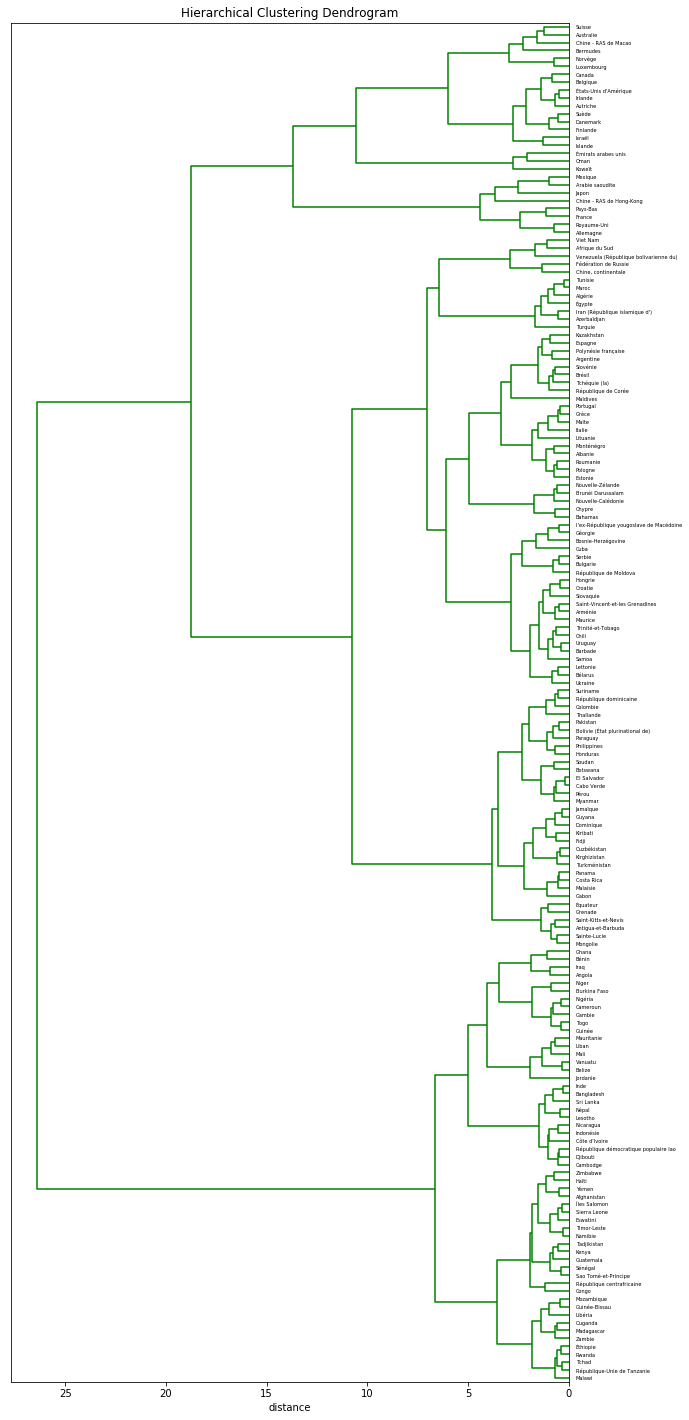

In [99]:
# préparation des données pour le clustering
X = df_complet.values
names = df_complet.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
# On met pour chaque variable une moyenne égale à 0 et un écart-type égal à 1, pour éviter l'effet échelle entre les variables

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')
# Stratégie d'aggregation, comment aggréger deux classes qui sont proches. Le choix de la distance, on prend la distance Euclidienne car var quantitatives
# De manière simplifiée, cette méthode cherche à minimiser l’inertie intra-classe et à maximiser l’inertie inter-classe afin d’obtenir des classes les plus homogènes possibles. Cette méthode est souvent incorrectement présentée comme une méthode de minimisation de la variance alors qu’au sens strict Ward vise l’augmentation mininum de la somme des carrés (“minimum increase of sum-of-squares (of errors)”)7.

# Affichage du dendrogramme
plot_dendrogram(Z, names)

# ACP sur tous les pays

In [100]:
# Les variables se situent loin du centre du cercle, moyennement bien représenté
# Coupage en 5 clusters
clusters = fcluster(Z, 5, criterion='maxclust')
# la plus forte perte d'inertie inter-classe

In [101]:
hierarchy = pd.DataFrame({"Pays":df_complet.index,"cluster":clusters})
hierarchy.head()

,Pays,cluster
0,Afghanistan,1
1,Afrique du Sud,3
2,Albanie,3
3,Algérie,3
4,Allemagne,4


In [102]:
df_complet=pd.merge(df_complet,hierarchy,on='Pays') # On ajoute les clusters à la tabe complet
df_complet=df_complet.set_index('Pays')
df_complet.to_csv("Liste de tous les pays avec cluster.csv", index=True)
df_complet.head()

,dispo alim (kcal/pers/an),dispo prot (g/pers/an),prop. prot animale (%),pop. growth (%),PIB/hab ($),imp. chicken 2013 (k tonnes),cluster
Pays,,,,,,,
Afghanistan,761755,21264.90,0.210,13.0,681.033974,48,1
Afrique du Sud,1102300,31145.45,0.426,5.0,6818.736993,356,3
Albanie,1163620,40650.05,0.533,1.0,4376.970549,25,3
Algérie,1201945,33550.80,0.272,10.0,5471.866638,3,3
Allemagne,1278595,37007.35,0.606,-1.0,46176.177749,788,4


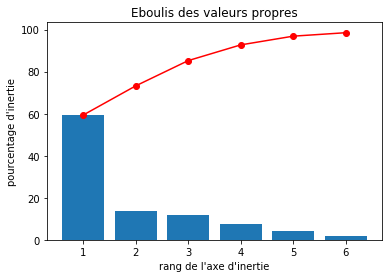

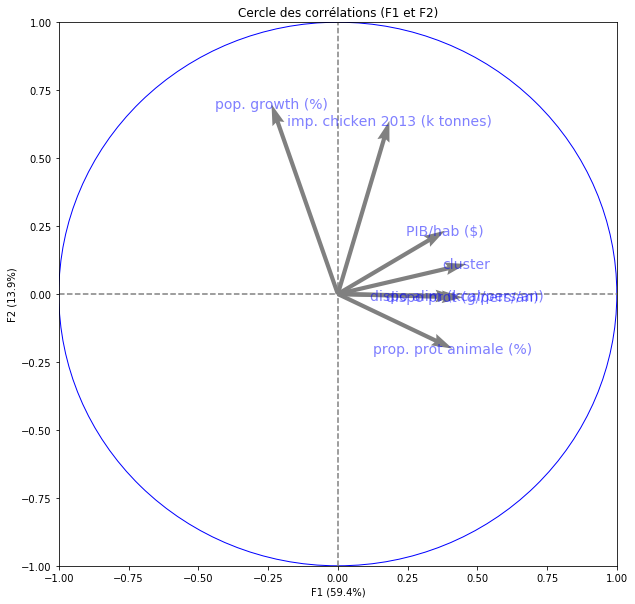

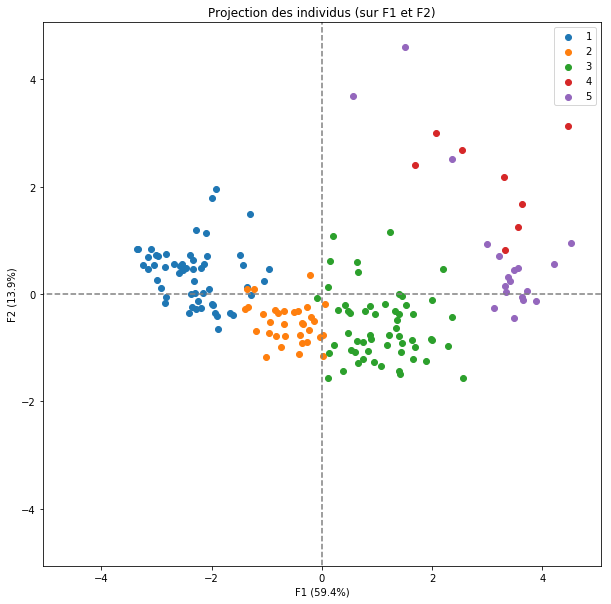

In [103]:
# choix du nombre de composantes à calculer
n_comp = 6


# selection des colonnes à prendre en compte dans l'ACP
data_pca = df_complet

# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
names = df_complet.index # ou data.index pour avoir les intitulés
features = df_complet.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=df_complet.cluster)

plt.show()

# On calcule les centroïdes

In [104]:
df_croissance_pop=df_complet.groupby(['cluster'])['pop. growth (%)'].mean().reset_index()
df_croissance_pop

,cluster,pop. growth (%)
0,1,12.654545
1,2,6.000000
2,3,2.403509
3,4,3.125000
4,5,9.789474


In [105]:
df_import_vol=df_complet.groupby(['cluster'])['imp. chicken 2013 (k tonnes)'].mean().reset_index()
df_import_vol

,cluster,imp. chicken 2013 (k tonnes)
0,1,32.272727
1,2,18.242424
2,3,76.456140
3,4,820.625000
4,5,89.105263


In [106]:
df_proportion_prot=df_complet.groupby(['cluster'])['prop. prot animale (%)'].mean().reset_index()
df_proportion_prot

,cluster,prop. prot animale (%)
0,1,0.245091
1,2,0.474121
2,3,0.500895
3,4,0.582875
4,5,0.600632


In [107]:
df_dispo_prot=df_complet.groupby(['cluster'])['dispo prot (g/pers/an)'].mean().reset_index()
df_dispo_prot

,cluster,dispo prot (g/pers/an)
0,1,22447.367273
1,2,26818.651515
2,3,34179.048246
3,4,37521.087500
4,5,39079.973684


In [108]:
df_dispo_cal=df_complet.groupby(['cluster'])['dispo alim (kcal/pers/an)'].mean().reset_index()
df_dispo_cal

,cluster,dispo alim (kcal/pers/an)
0,1,8.918609e+05
1,2,9.675818e+05
2,3,1.140657e+06
3,4,1.184744e+06
4,5,1.236851e+06


In [109]:
df_pibc=df_complet.groupby(['cluster'])['PIB/hab ($)'].mean().reset_index()
df_pibc

,cluster,PIB/hab ($)
0,1,1887.163650
1,2,5929.278328
2,3,14196.905830
3,4,37075.477707
4,5,61533.256262


In [110]:
# on crée la table de carectérisation selon la moyenne de chaque cluster
df_caracterisation=pd.merge(df_croissance_pop,df_pibc,on='cluster')
df_caracterisation=pd.merge(df_caracterisation,df_import_vol,on='cluster')
df_caracterisation=pd.merge(df_caracterisation,df_proportion_prot,on='cluster')
df_caracterisation=pd.merge(df_caracterisation,df_dispo_prot,on='cluster')
df_caracterisation=pd.merge(df_caracterisation,df_dispo_cal,on='cluster')
df_caracterisation=df_caracterisation.set_index('cluster')
df_caracterisation.loc['Mean'] = df_caracterisation.mean() # Ajouter la moyenne totale de toutes les variables, afin de pouvoir comparer les moyennes de chaque cluster par rapport au moyenne de l'échantillon total
round(df_caracterisation, 2)
df_caracterisation.to_csv("Centroïdes des clusters.csv", index=True)

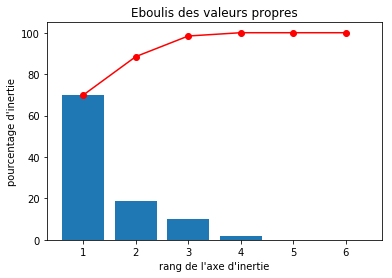

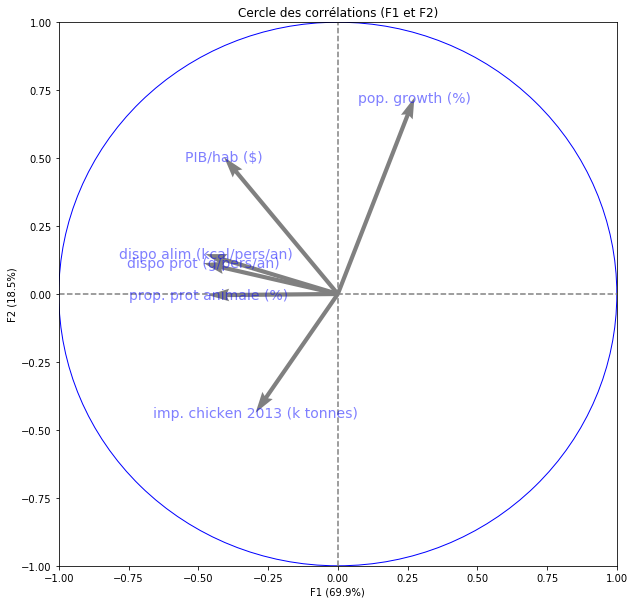

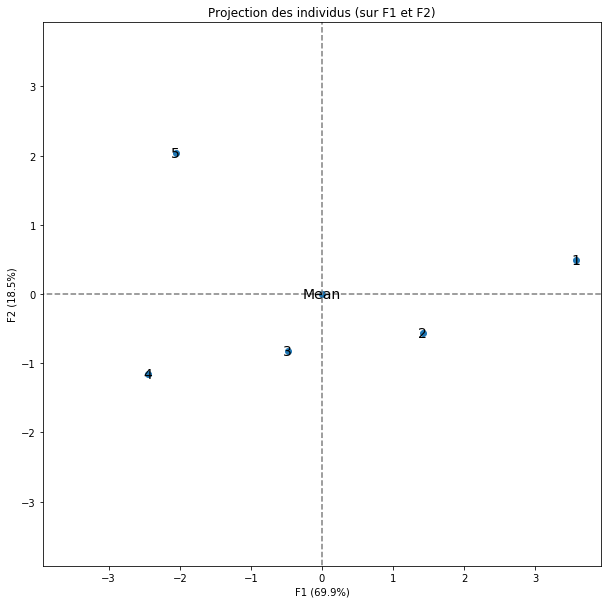

In [111]:
# choix du nombre de composantes à calculer
n_comp = 6


# selection des colonnes à prendre en compte dans l'ACP
data_pca = df_caracterisation

# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
names = df_caracterisation.index # ou data.index pour avoir les intitulés
features = df_caracterisation.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], labels = np.array(names))

plt.show()

# Analyses de nos cluster 4+5

In [112]:
# on ajoute la variabe population pour déterminer la taille du marché + la croissance d'importations depuis 2008 pour voir une tendance
df_target=df_complet[(df_complet['cluster']==4) | (df_complet['cluster']==5)]
df_target=pd.merge(df_target,df_pop2013, on='Pays')
df_target=df_target.drop(columns=['dispo alim (kcal/pers/an)','dispo prot (g/pers/an)','prop. prot animale (%)','pop. growth (%)','cluster'])
df_target=df_target.set_index('Pays')
df_target

,PIB/hab ($),imp. chicken 2013 (k tonnes),2013
Pays,,,
Allemagne,46176.177749,788,82727000
Arabie saoudite,24934.386142,879,28829000
Australie,66301.306788,17,23343000
Autriche,50137.519579,105,8495000
Belgique,46713.462219,252,11104000
Bermudes,90329.786048,4,65000
Canada,52264.959967,226,35182000
Chine - RAS de Hong-Kong,38566.712121,1186,7204000
Chine - RAS de Macao,89525.344880,17,566000


In [113]:
# Ajoutons la distance du pays comme variable
# Justifier la supposition que la distance est une variable discriminante, dire que la société a pas d'expertise, finalement comparé les coûts pour des pays comme Arabie Saoudite ou le Canada

df_distance = pd.read_csv('distance_pays.csv', sep=',')

In [114]:
df_target=pd.merge(df_target,df_distance, on='Pays')
df_target=df_target.set_index('Pays')
df_target.head()

,PIB/hab ($),imp. chicken 2013 (k tonnes),2013,distance (km)
Pays,,,,
Allemagne,46176.177749,788,82727000,868
Arabie saoudite,24934.386142,879,28829000,4684
Australie,66301.306788,17,23343000,16927
Autriche,50137.519579,105,8495000,1032
Belgique,46713.462219,252,11104000,259


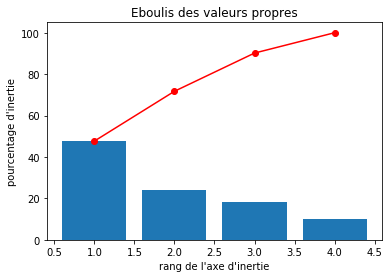

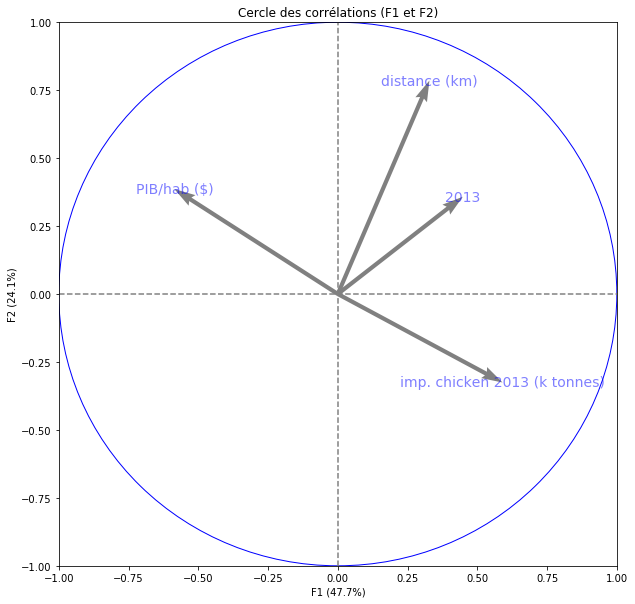

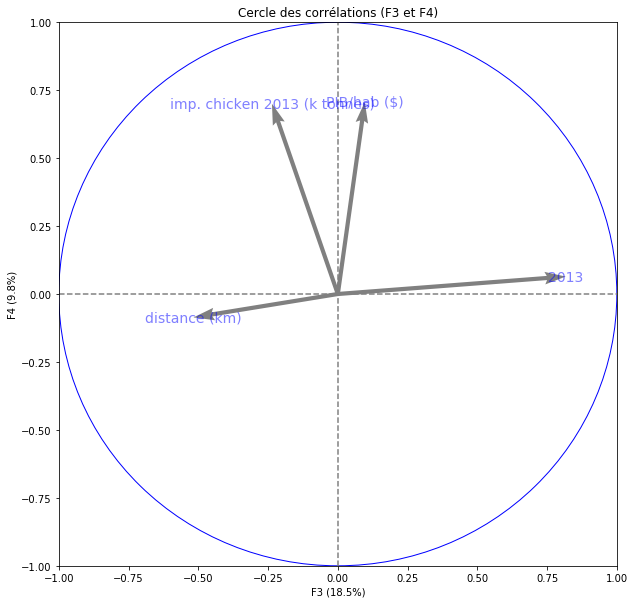

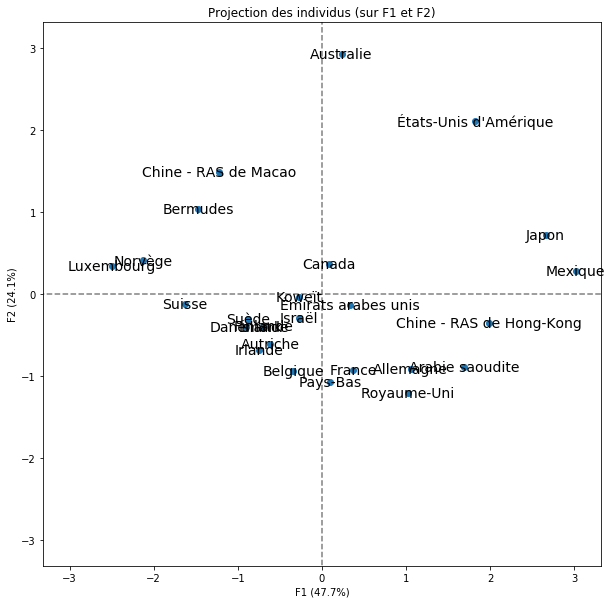

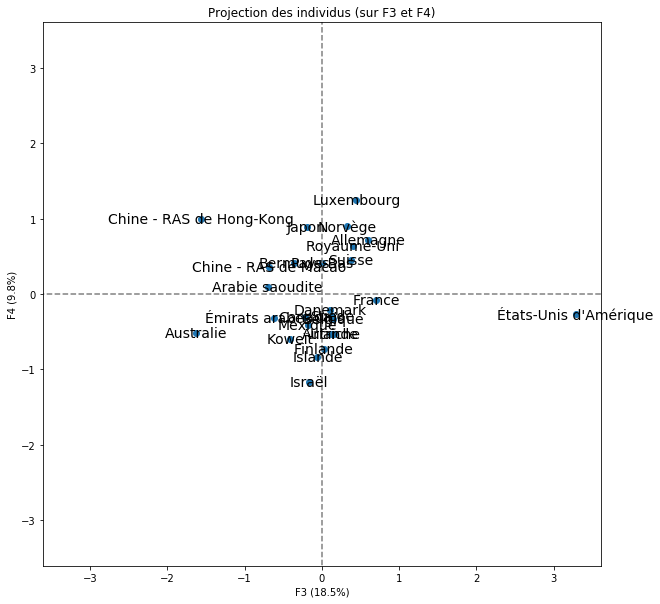

In [115]:
# choix du nombre de composantes à calculer
n_comp = 4


# selection des colonnes à prendre en compte dans l'ACP
data_pca = df_target

# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
names = df_target.index # ou data.index pour avoir les intitulés
features = df_target.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(3,4)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(3,4)], labels = np.array(names))

plt.show()

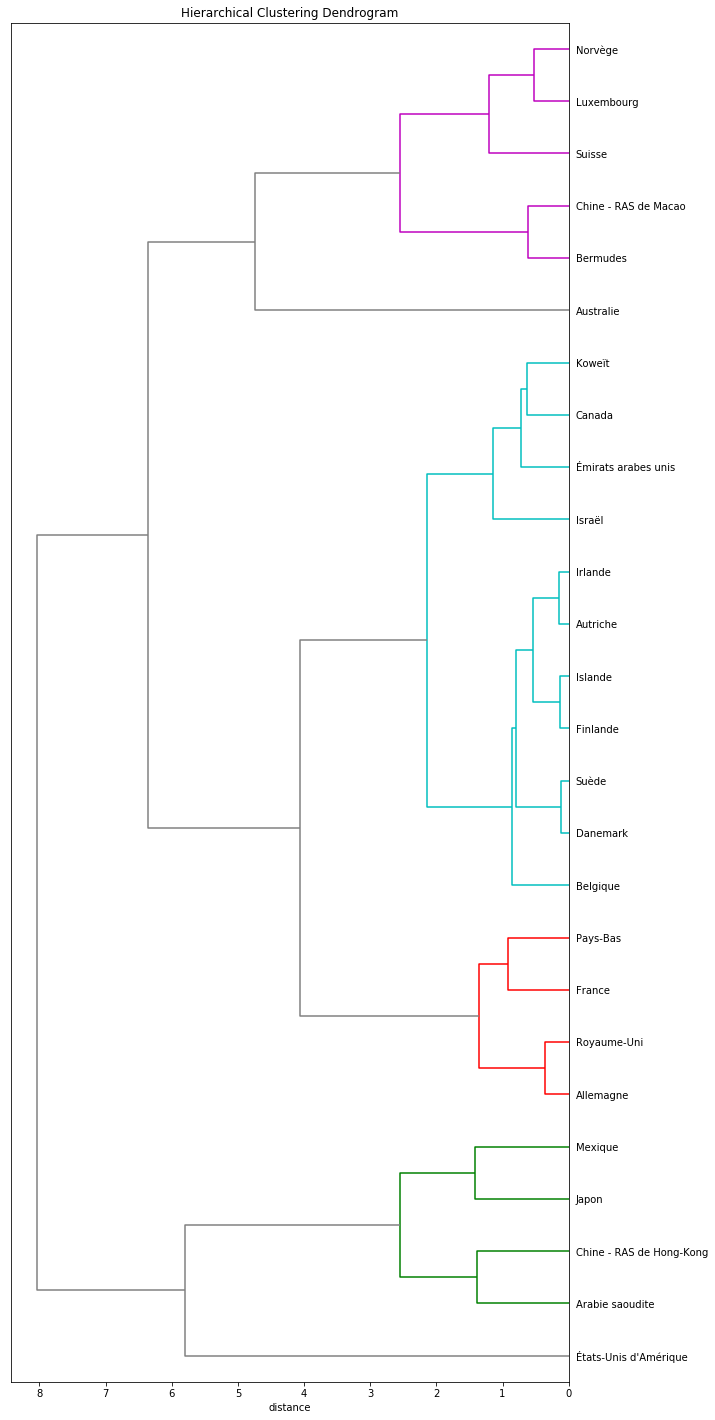

In [116]:
# préparation des données pour le clustering
X = df_target.values
names = df_target.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
# On met pour chaque variable une moyenne égale à 0 et un écart-type égal à 1, pour éviter l'effet échelle entre les variables

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')
# Stratégie d'aggregation, comment aggréger deux classes qui sont proches. Le choix de la distance, on prend la distance Euclidienne car var quantitatives
# Justifier choix de Ward

# Affichage du dendrogramme
plot_dendrogram2(Z, names)

In [117]:
# Coupage en 6 clusters
clusters2 = fcluster(Z, 6, criterion='maxclust')
# la plus forte perte d'inertie inter-classe

In [118]:
targeting = pd.DataFrame({"Pays":df_target.index,"cluster":clusters2})
df_targeting=pd.merge(df_target,targeting,on="Pays")
df_targeting.set_index('Pays')

,PIB/hab ($),imp. chicken 2013 (k tonnes),2013,distance (km),cluster
Pays,,,,,
Allemagne,46176.177749,788,82727000,868,3
Arabie saoudite,24934.386142,879,28829000,4684,1
Australie,66301.306788,17,23343000,16927,6
Autriche,50137.519579,105,8495000,1032,4
Belgique,46713.462219,252,11104000,259,4
Bermudes,90329.786048,4,65000,5766,5
Canada,52264.959967,226,35182000,5646,4
Chine - RAS de Hong-Kong,38566.712121,1186,7204000,8219,1
Chine - RAS de Macao,89525.344880,17,566000,8219,5


In [119]:
# On calcule les centroïdes
df_tarpib=df_targeting.groupby(['cluster'])['PIB/hab ($)'].mean().reset_index()
df_tarimp=df_targeting.groupby(['cluster'])['imp. chicken 2013 (k tonnes)'].mean().reset_index()
df_tarpop=df_targeting.groupby(['cluster'])[2013].mean().reset_index()
df_tardist=df_targeting.groupby(['cluster'])['distance (km)'].mean().reset_index()

In [120]:
# On fusionne le tout
df_targetop=pd.merge(df_tarpib,df_tarimp,on="cluster")
df_targetop=pd.merge(df_targetop,df_tarpop,on="cluster")
df_targetop=pd.merge(df_targetop,df_tardist,on="cluster")
df_targetop=df_targetop.set_index('cluster')
df_targetop.loc['Mean'] = df_targetop.mean() # Ajouter la moyenne totale de toutes les variables, afin de pouvoir comparer les moyennes de chaque cluster par rapport au moyenne de l'échantillon total
round(df_targetop,2)

,PIB/hab ($),imp. chicken 2013 (k tonnes),2013,distance (km)
cluster,,,,
1,28520.62,992.50,7.137725e+07,7955.50
2,52898.82,101.00,3.200510e+08,6162.00
3,45630.34,648.75,5.679025e+07,409.00
4,49790.65,124.36,9.163818e+06,2480.91
5,96193.17,17.80,2.856400e+06,3203.60
6,66301.31,17.00,2.334300e+07,16927.00
Mean,56555.82,316.90,8.059695e+07,6189.67


In [121]:
df_choice=df_targeting[(df_targeting['cluster']==4)]
df_choice=df_choice.drop(columns=['cluster'])
df_choice

,Pays,PIB/hab ($),imp. chicken 2013 (k tonnes),2013,distance (km)
3,Autriche,50137.519579,105,8495000,1032
4,Belgique,46713.462219,252,11104000,259
6,Canada,52264.959967,226,35182000,5646
9,Danemark,60942.805627,101,5619000,1264
10,Finlande,49659.588178,16,5426000,1909
12,Irlande,51130.077752,80,4627000,574
13,Islande,47544.160857,1,330000,2062
14,Israël,37397.810740,0,7733000,3330
16,Koweït,48401.609794,139,3369000,4428
23,Suède,60190.029595,73,9571000,1545


In [122]:
df_choice.sort_values('imp. chicken 2013 (k tonnes)', axis=0, ascending=False)

,Pays,PIB/hab ($),imp. chicken 2013 (k tonnes),2013,distance (km)
24,Émirats arabes unis,43315.138419,375,9346000,5241
4,Belgique,46713.462219,252,11104000,259
6,Canada,52264.959967,226,35182000,5646
16,Koweït,48401.609794,139,3369000,4428
3,Autriche,50137.519579,105,8495000,1032
9,Danemark,60942.805627,101,5619000,1264
12,Irlande,51130.077752,80,4627000,574
23,Suède,60190.029595,73,9571000,1545
10,Finlande,49659.588178,16,5426000,1909
13,Islande,47544.160857,1,330000,2062


# Tests statistiques

In [123]:
# Test paramétrique ou non paramétrique, les deux hyphothèses, la statistique du test suit loi normale
# Vérifier les hypothèses du Test
scipy.stats.shapiro(df_complet['dispo alim (kcal/pers/an)'])

(0.9827972054481506, 0.03191808983683586)

In [131]:
df_cluster1=df_complet[(df_complet['cluster']==1)]
df_cluster4=df_complet[(df_complet['cluster']==4)]

In [133]:
# Test de Student
# Testez s'ils ont la même distribution Gaussienne, différente moyenne et différente variance, paramètres différents
scipy.stats.ttest_ind(df_cluster4['dispo alim (kcal/pers/an)'],df_cluster1['dispo alim (kcal/pers/an)'],equal_var=True)

Ttest_indResult(statistic=7.4575516539905555, pvalue=3.780515014904937e-10)

In [130]:
df_targeting.sort_values('imp. chicken 2013 (k tonnes)', axis=0, ascending=False)

,Pays,PIB/hab ($),imp. chicken 2013 (k tonnes),2013,distance (km),cluster
7,Chine - RAS de Hong-Kong,38566.712121,1186,7204000,8219,1
15,Japon,40180.809978,1056,127144000,9716,1
1,Arabie saoudite,24934.386142,879,28829000,4684,1
18,Mexique,10400.569944,849,122332000,9203,1
21,Royaume-Uni,42385.080963,812,63384000,341,3
0,Allemagne,46176.177749,788,82727000,868,3
20,Pays-Bas,51466.478134,572,16759000,427,3
11,France,42493.606628,423,64291000,0,3
24,Émirats arabes unis,43315.138419,375,9346000,5241,4
4,Belgique,46713.462219,252,11104000,259,4


/Users/eddoha/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


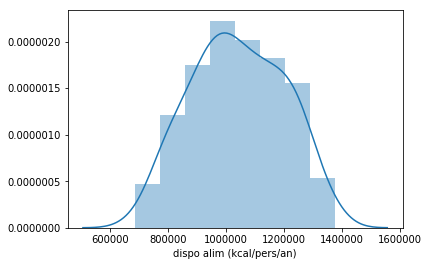

In [127]:
sns.distplot(df_complet['dispo alim (kcal/pers/an)'])